**Sentiment Analysis for the Transport Industry Customer Feedback Reviews**

**Importing Libraries**

In [ ]:
#importing libraries
#data manipulation
import pandas as pd
import numpy as np
import nltk
import re
import string
import tweepy
import textblob
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#methods and stop words text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#machine learning libraries
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt


**English Stopwords**

In [ ]:
#creating a stopwords set, punkt and wordnet used in lemmatizing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
stop_words.remove('not')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Load the Dataset**

In [ ]:
#importing our dataset that has been labelled 
df = pd.read_csv('./drive/MyDrive/Colab Notebooks/Uber Kenya Sentiment Model/a1_TheFIERSLabeled_Dataset.tsv', delimiter = '\t', quoting = 3)
df


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
895,I want to first say our server was great and w...,1
896,The pizza selections are good.,1
897,"I had strawberry tea, which was good.",1
898,Highly unprofessional and rude to a loyal patron!,0


In [ ]:
df.columns = ['tweet', 'sentiment']

**Exploratory Data Analysis**

In [ ]:
df.head()

,tweet,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [ ]:
#features in dataset
df.columns

Index(['tweet', 'sentiment'], dtype='object')

In [ ]:
#Length of the dataset
print('length of data is', len(df))

length of data is 900


In [ ]:
#Shape of dataset
df.shape

(900, 2)

In [ ]:
#Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      900 non-null    object
 1   sentiment  900 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.2+ KB


In [ ]:
#Datatypes of all columns
df.dtypes

tweet        object
sentiment     int64
dtype: object

In [ ]:
#Checking for Null values
np.sum(df.isnull().any(axis = 1))

0

In [ ]:
df.dropna(inplace=True)

In [ ]:
#Rows and columns in the dataset
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   2
Count of rows in the data is:   900


In [ ]:
df.sample(n=100).to_csv('uberkenyalabeltrain-data.csv', index=False)

**Preprocessing the tweet text**
1. casing
2. Noise removal
3. Stopword removal
4. Text Normalisation(Stemming and Lemmatization)

In [ ]:
#Changing case to lowercase for all our text data
df['tweet']= df['tweet'].str.lower()
df['tweet'].head()

0                             wow... loved this place.
1                                   crust is not good.
2            not tasty and the texture was just nasty.
3    stopped by during the late may bank holiday of...
4    the selection on the menu was great and so wer...
Name: tweet, dtype: object

In [ ]:
#Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['tweet']= df['tweet'].apply(lambda x: cleaning_punctuations(x))
df['tweet'].head()

0                                 wow loved this place
1                                    crust is not good
2             not tasty and the texture was just nasty
3    stopped by during the late may bank holiday of...
4    the selection on the menu was great and so wer...
Name: tweet, dtype: object

In [ ]:
#Removal of repetitive characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df['tweet']= df['tweet'].apply(lambda x: cleaning_repeating_char(x))
df['tweet'].head()

0                                 wow loved this place
1                                    crust is not good
2             not tasty and the texture was just nasty
3    stopped by during the late may bank holiday of...
4    the selection on the menu was great and so wer...
Name: tweet, dtype: object

In [ ]:
#URL’s removal
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['tweet']= df['tweet'].apply(lambda x: cleaning_URLs(x))
df['tweet'].head()

0                                 wow loved this place
1                                    crust is not good
2             not tasty and the texture was just nasty
3    stopped by during the late may bank holiday of...
4    the selection on the menu was great and so wer...
Name: tweet, dtype: object

In [ ]:
#Cleaning and removing Numeric characters
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['tweet']= df['tweet'].apply(lambda x: cleaning_numbers(x))
df['tweet'].head()

0                                 wow loved this place
1                                    crust is not good
2             not tasty and the texture was just nasty
3    stopped by during the late may bank holiday of...
4    the selection on the menu was great and so wer...
Name: tweet, dtype: object

In [ ]:
#definition and removal of stopwords
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s',
              'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['tweet']= df['tweet'].apply(lambda text: cleaning_stopwords(text))
df['tweet'].head()

0                                      wow loved place
1                                       crust not good
2                              not tasty texture nasty
3    stopped late may bank holiday off rick steve r...
4                          selection menu great prices
Name: tweet, dtype: object

In [ ]:
"""#import libraries and use 'correct' function reduces my accuracy
df['tweet'] = df['tweet'].apply(lambda x: str(TextBlob(x).correct()))
df['tweet'].head()"""

"#import libraries and use 'correct' function reduces my accuracy\ndf['tweet'] = df['tweet'].apply(lambda x: str(TextBlob(x).correct()))\ndf['tweet'].head()"

In [ ]:
#stemming
ps = PorterStemmer()
def stemming(data):
  stemmed_words = [ps.stem(w) for w in STOPWORDS]
  return data
df['tweet']= df['tweet'].apply(lambda x: stemming(x))
df['tweet'].head()



0                                      wow loved place
1                                       crust not good
2                              not tasty texture nasty
3    stopped late may bank holiday off rick steve r...
4                          selection menu great prices
Name: tweet, dtype: object

In [ ]:
#Code for lemmatize improves accuracy by 0.2%
"""df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['tweet'].head()"""
#Lemmatization
import nltk
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df['tweet'] = df['tweet'].apply(lambda x: lemmatizer_on_text(x))
df['tweet'].head()

0                                      wow loved place
1                                       crust not good
2                              not tasty texture nasty
3    stopped late may bank holiday off rick steve r...
4                          selection menu great prices
Name: tweet, dtype: object

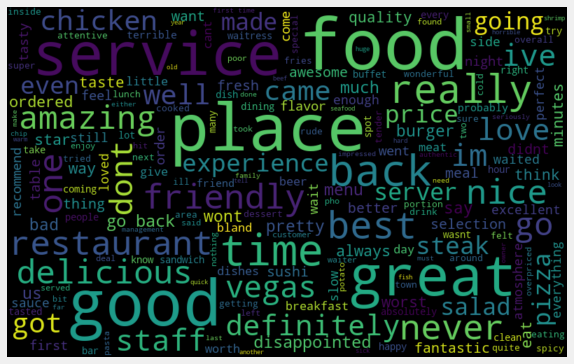

In [ ]:
#visualize the frequent words
all_words = " ".join([str(sentence) for sentence in df['tweet']])
wordcloud = WordCloud(width = 800, height=500, random_state= 42, max_font_size = 100).generate(all_words)
#plot the graph
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [ ]:
"""#Tokenization
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
df['tweet']= df['tweet'].apply(tokenizer.tokenize)
df['tweet'].head()"""

"#Tokenization\nfrom nltk.tokenize import RegexpTokenizer\ntokenizer = RegexpTokenizer(r'w+')\ndf['tweet']= df['tweet'].apply(tokenizer.tokenize)\ndf['tweet'].head()"

In [ ]:
#Separating input feature and label
X=df.tweet
y=df.sentiment

In [ ]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [ ]:
#Fitting the TF-IDF Vectorizer 500000
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=1420)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  1420


In [ ]:
#Transform the data using TF-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [ ]:
X_train.shape, X_test.shape

((720, 1420), (180, 1420))

In [ ]:
def model_Evaluate(model):
# Predict values for Test dataset
  y_pred = model.predict(X_test) 
# Print the evaluation metrics for the dataset
  print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Model fitting (Naive Bayes)** now to train our sentiment based review classification

In [ ]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)

BernoulliNB()

**How Good is our Naive Bayes Model**

In [ ]:
#How well does our Naive Bayes Model classify a good review as good and a bad review as bad
y_pred = BNBmodel.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

#confusion_matrix how our model performs on unseen data
cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix is:", cm)

#the accuracy score
accuracy_score(y_test, y_pred)

The Confusion Matrix is: [[42 36]
 [13 89]]


0.7277777777777777

**Naive Bayes Model Evaluation**

              precision    recall  f1-score   support

           0       0.76      0.54      0.63        78
           1       0.71      0.87      0.78       102

    accuracy                           0.73       180
   macro avg       0.74      0.71      0.71       180
weighted avg       0.73      0.73      0.72       180



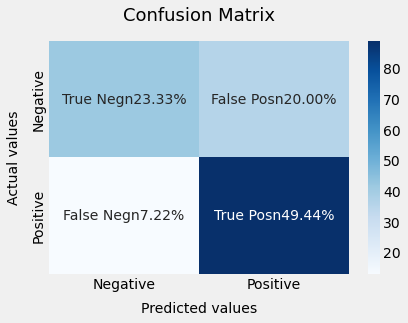

In [ ]:
model_Evaluate(BNBmodel)
# y_pred1 = BNBmodel.predict(X_test)

**Model fitting (Logistic Regression)** now to train our sentiment based review classification

In [ ]:
from sklearn.linear_model import  LogisticRegression
classifier2 = LogisticRegression()
classifier2.fit(X_train, y_train)

LogisticRegression()

**How Good is our Logistic Regression Model**

In [ ]:
#how well does our model classify a good review as good and a bad review as bad
y_pred = classifier2.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

#confusion_matrix how our model performs on unseen data
cm = confusion_matrix(y_test, y_pred)
print( cm)

#the accuracy score
accuracy_score(y_test, y_pred)

[[58 20]
 [13 89]]


0.8166666666666667

**Logistic Regression Model Evaluation**

              precision    recall  f1-score   support

           0       0.82      0.74      0.78        78
           1       0.82      0.87      0.84       102

    accuracy                           0.82       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180



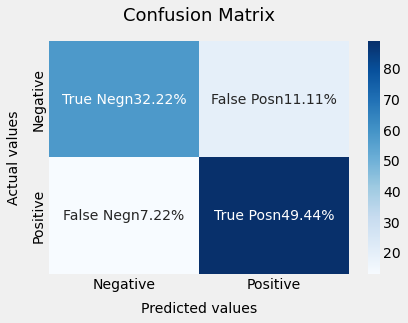

In [ ]:
#Model Evaluation
model_Evaluate(classifier2)

**Model fitting (SVC Model)** now to train our sentiment based review classification

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

LinearSVC()

**How Good is our SVC Model Model**

In [ ]:
#how well does our model classify a good review as good and a bad review as bad
y_pred = SVCmodel.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

#confusion_matrix how our model performs on unseen data
cm = confusion_matrix(y_test, y_pred)
print(cm)

#the accuracy score
accuracy_score(y_test, y_pred)

[[66 12]
 [15 87]]


0.85

**SVC Model Model Evaluation**

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        78
           1       0.88      0.85      0.87       102

    accuracy                           0.85       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.85      0.85      0.85       180



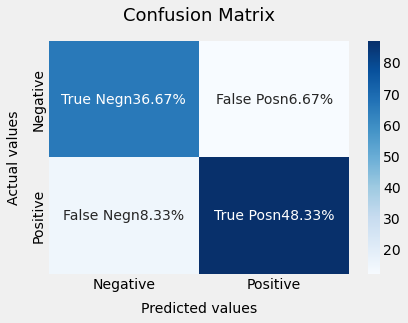

In [ ]:
#Model Evaluation
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

**ROC CURVE**

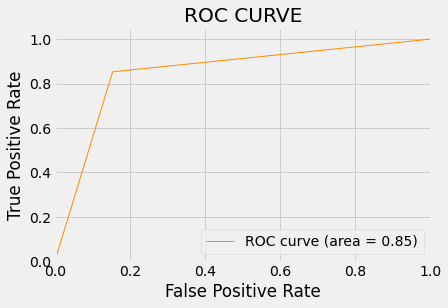

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

**Exporting SVC Classifier to Google Drive**

In [ ]:
# Exporting SVC Classifier to later use it in prediction for the fresh reviews
import joblib
joblib.dump(SVCmodel, './drive/MyDrive/Colab Notebooks/Uber Kenya Sentiment Model/UberSVCmodel_classifier')

['./drive/MyDrive/Colab Notebooks/Uber Kenya Sentiment Model/UberSVCmodel_classifier']

**Model Serialization**

In [ ]:
#.pkl file to be used for deployment

import joblib
joblib.dump(SVCmodel, './drive/MyDrive/Colab Notebooks/Uber Kenya Sentiment Model/UberSVCmodel_classifier.pkl')

['./drive/MyDrive/Colab Notebooks/Uber Kenya Sentiment Model/UberSVCmodel_classifier.pkl']

In [ ]:
joblib.dump(vectoriser, './drive/MyDrive/Colab Notebooks/Uber Kenya Sentiment Model/UberSVCmodel_vectorizer.pkl')

['./drive/MyDrive/Colab Notebooks/Uber Kenya Sentiment Model/UberSVCmodel_vectorizer.pkl']

In [ ]:
joblib.dump(STOPWORDS, './drive/MyDrive/Colab Notebooks/Uber Kenya Sentiment Model/UberSVCmodel_STOPWORDS.pkl')

['./drive/MyDrive/Colab Notebooks/Uber Kenya Sentiment Model/UberSVCmodel_STOPWORDS.pkl']

**Trying Out Prediction**

In [ ]:
review = ["The ride was smooth, comfortable and the driver was so polite"]

review  = vectoriser.transform(review)
prediction = SVCmodel.predict(review)
if prediction == 1:
  print("Result: This review is positive")
else:
  print("Result: This review is negative")

Result: This review is positive


**Trying to load the Classifier**

In [ ]:
new_review=["The driver was rude and disrespectful, he overcharged me"]
#loading the vectoriser
vec = joblib.load('./drive/MyDrive/Colab Notebooks/Uber Kenya Sentiment Model/UberSVCmodel_vectorizer.pkl')
new_review = vec.transform(new_review)
#loading the classifyng model
model = joblib.load('./drive/MyDrive/Colab Notebooks/Uber Kenya Sentiment Model/UberSVCmodel_classifier.pkl')
#doing the prediction
pred = model.predict(new_review)

if pred == 1:
  print("Result: This review is positive")
else:
  print("Result: This review is negative")

Result: This review is negative
